# Loading Simind Data

First we'll import all required libraries

In [1]:
import sys
sys.path.append('/home/ubuntu/tormography/src')
import os
from pytomography.algorithms.osem import OSEMNet, get_osem_net
from pytomography.projections import ForwardProjectionNet, BackProjectionNet
from pytomography.corrections import CTCorrectionNet
from pytomography.io import simind_projections_to_data, simind_CT_to_data
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
path = '/home/ubuntu/tormography/test_files/'

Just like in regular PyTorch, we choose our computation device.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Now we can load in some projection data produced by SIMIND. It's important to check the header file to determine if the radial distances are specified in units of mm or cm (usually the detector is at least 15cm away from the patient).

In [4]:
filepath = os.path.join(path, 'xcatwb_tot_w2.h00')
object_meta, image_meta, projections = simind_projections_to_data(filepath, distance='mm')
projections.shape

torch.Size([1, 64, 128, 512])

This tells us we have 64 projections of matrix size 128x512. We can look at the image meta data to get more information. Information about the corresponding angle and radius for each projections is stored in `image_meta.radii` and `image_meta.angles` respectively. We can plot the projections:

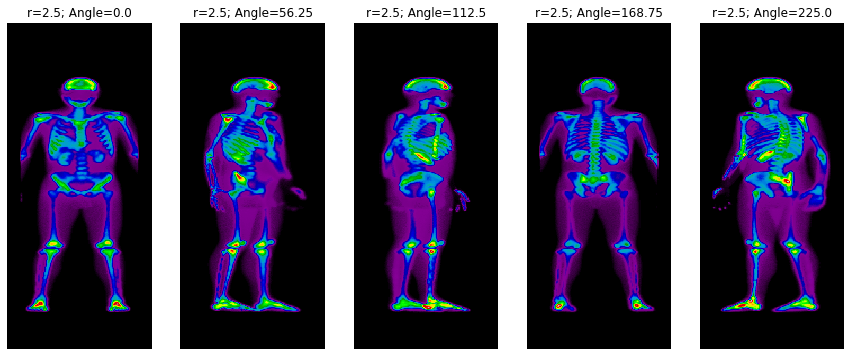

In [5]:
fig, axes = plt.subplots(1,5,figsize=(15,6))
for i, proj in enumerate([0,10,20,30,40]):
    axes[i].pcolormesh(projections[0][proj].T, cmap='nipy_spectral')
    axes[i].set_title(f'r={image_meta.radii[proj]}; Angle={image_meta.angles[proj]}')
    axes[i].axis('off')

The `object_meta` gives corresponding metadata about the shape and voxel spacing of the object which is to be constructed.

In [6]:
object_meta.shape

(128, 128, 512)

In [7]:
object_meta.dr

(0.47950000762939454, 0.47950000762939454, 0.47950000762939454)

We can use this information to create an `OSEMNet` object, which will be used for ordered subset expectation maximum reconstruction.

$$f_i^{(n+1)} = \frac{f_i^{(n)}}{\sum_j c_{ij} + \beta \frac{\partial V}{\partial f_r}|_{f_i=f_i^{(n)}}} \sum_j c_{ij}\frac{g_j}{\sum_i c_{ij}f_i^{(n)}} $$

First we need to give all required information for the forward projection operator $\sum_i c_{ij} a_i$ and the back projection operator $\sum_j c_{ij} b_j$ work.

* This amounts to defining the different image correction techniques we want to use. In some cases we'll want to adjust for phenomenon such as attenuation as PSF blurring.



## Basic Reconstruction

To start, we won't focus on any image correction techniques. We can define our forward and back projection nets as follows:

In [8]:
fp_net = ForwardProjectionNet(object_correction_nets=[],
                              image_correction_nets=[],
                              object_meta=object_meta,
                              image_meta=image_meta,
                              device=device)
bp_net = BackProjectionNet(object_correction_nets=[],
                           image_correction_nets=[],
                           object_meta=object_meta,
                           image_meta=image_meta,
                           device=device)

Projection networks work as follows: `fp_net` converts an object in to an image and `bp_net` converts an image into an object. We'll cover the specifics of this in later tutorials. All you need to understand for now is that they're used as mathematical tools inside the `OSEM` algorithm.

Since osem is an iterative algorithm, we need an initial object guess. A common initial guess is just an array of all ones. We can create this by using the `shape` attribute of the `object_meta` (which tells us the exact dimensions are objects will be)

In [9]:
initial_guess = torch.ones(object_meta.shape)
initial_guess.shape

torch.Size([128, 128, 512])

But as you may have noticed, the arrays constructed are typically 4 dimensional; there is a batch dimension out front. This dimension is included so that multiple images can be reconstructed at the same time, or multiple energy windows of the same image can be reconstructed at the same time. So even though we're only reconstructing one image, we need to add that extra dimension

In [10]:
initial_guess = initial_guess.unsqueeze(dim=0)
initial_guess.shape

torch.Size([1, 128, 128, 512])

Now we can combine everything we need in the `OSEMNet`:

In [11]:
osem_net = OSEMNet(object_initial=initial_guess,
                   forward_projection_net=fp_net,
                   back_projection_net=bp_net)

This network, in its present form, can be used to reconstruct many different images. We now need to tell us which image we want it to reconstruct:

In [12]:
osem_net.set_image(projections)

We can now use this algorithm to reconstruct our object with the desired number of iterations and subsets.

In [13]:
reconstructed_object = osem_net(n_iters=4, n_subsets=8)

The returned object is a pytorch tensor; we need to convert it to a numpy array before we can do any plotting with it. We'll also index using [0] to get the first element of the batch (in this case there's only one object in the batch)

In [14]:
reconstructed_object = reconstructed_object[0].cpu().numpy()

Now we can plot some slices of the object. Note that there is no correction techniques used.

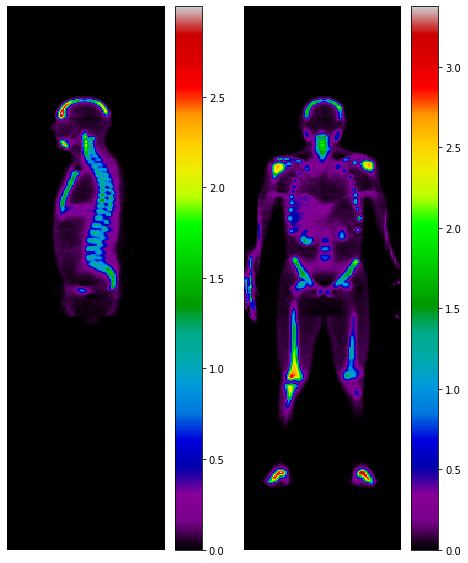

In [15]:
plt.subplots(1,2,figsize=(12,10))
plt.subplot(131)
plt.pcolormesh(reconstructed_object[64].T, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.subplot(132)
plt.pcolormesh(reconstructed_object[:,64].T, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.show()

## Adding Attenuation Correction

To encorporate CT Correction, you must ensure your CT object is aligned with the SPECT data. In particular:
1. If the dimension of the projections are `[batch_size, Ltheta, Lr, LZ]` then the dimension of the CT should be `[1, Lr, Lr, Lz]`. 
2. The projections should be aligned with the CT. This can be checked by comparing (i) the projection at 0 degrees with a coronal view of the CT and (ii) the projection at 90 degrees with a sagital view of the CT

In [16]:
CT = simind_CT_to_data(os.path.join(path, 'xcat_wb.hct'))

This returns a 3D tensor, but remember we need all tensors to be 4 dimensional

In [17]:
CT = CT.unsqueeze(dim=0)

Now we can plot:

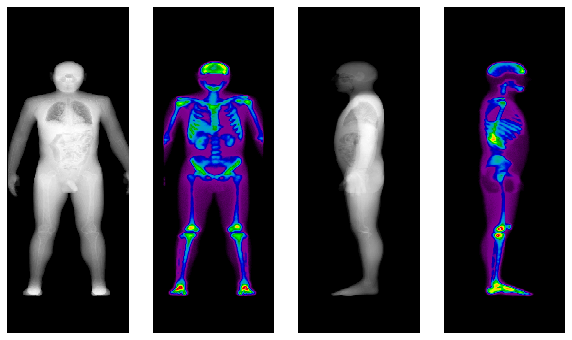

In [18]:
plt.subplots(1, 4, figsize=(10,6))
plt.subplot(141)
plt.pcolormesh(CT[0].sum(axis=1).T, cmap='Greys_r')
plt.axis('off')
plt.subplot(142)
plt.pcolormesh(projections[0][0].T, cmap='nipy_spectral')
plt.axis('off')
plt.subplot(143)
plt.pcolormesh(CT[0].sum(axis=0).T, cmap='Greys_r')
plt.axis('off')
plt.subplot(144)
plt.pcolormesh(projections[0][16].T, cmap='nipy_spectral')
plt.axis('off')
plt.show()

Note that the sagital views are opposite to eachother: but this is what we expect. The horizontal axis of the projection (SPECT image) is the $r$ axis, which is aligned opposite to the $y$ axis at a projection angle of 90 degrees.

With this CT image, we can create a correction network to model attenuation correction:

In [19]:
ct_net = CTCorrectionNet(object_meta, image_meta, CT, device=device)

Then we simply need to add this correction to the forward and back projection networks

In [20]:
fp_net = ForwardProjectionNet(object_correction_nets=[ct_net],
                              image_correction_nets=[],
                              object_meta=object_meta,
                              image_meta=image_meta,
                              device=device)
bp_net = BackProjectionNet(object_correction_nets=[ct_net],
                           image_correction_nets=[],
                           object_meta=object_meta,
                           image_meta=image_meta,
                           device=device)

And then do everything the same as above:

In [21]:
initial_guess = torch.ones(object_meta.shape).unsqueeze(dim=0)
osem_net = OSEMNet(object_initial=initial_guess,
                   forward_projection_net=fp_net,
                   back_projection_net=bp_net)
osem_net.set_image(projections)
reconstructed_object = osem_net(n_iters=4, n_subsets=8)
reconstructed_object = reconstructed_object[0].cpu().numpy()

And we can plot our new, attenuation corrected, reconstructions:

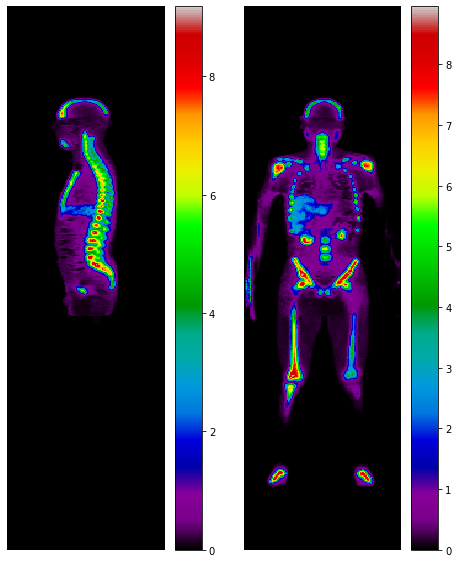

In [22]:
plt.subplots(1,2,figsize=(12,10))
plt.subplot(131)
plt.pcolormesh(reconstructed_object[64].T, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.subplot(132)
plt.pcolormesh(reconstructed_object[:,64].T, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.show()

Compared to the images reconstructed without attenuation correction, the number of predicted counts is much higher, and the concentration is relatively higher in bones.